# Análisis Bursátil para compra-venta de acciones.

## ¿Qué ofrece?

1) Una visión por técnico de la correlación entre los precios de las empresas que se faciliten en el excel de soporte. Hay que incluir tanto las empresas en cartera como la lista de las que se quieran comprar, para confirmar si correlacionan con las existentes o no.

2) Regresión lineal sobre el precio de la acción en bolsa para todas las empresas de la lista.

3) Análisis de beneficio vs riesgo (entendido como en el CFA: riesgo = volatilidad).

4) Breve descripción visual de la cartera actual con las pérdidas y ganancias de cada empresa en cartera.

## ¿Qué limitación tiene?

No se puede establecer distintas fechas para cada acción. Lo dejo para la siguiente mejora.

                                                       De Ismaele para los Momentums

In [1]:
# Importar librerías

from pandas_datareader import data as wb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from seaborn import lmplot
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML
from ipywidgets import interact
from scipy import stats
import statsmodels.api as sm 

In [2]:
# Marco temporal del análisis: indicar fechas que no sean festivos ni fin de semana. yyyy-mm-dd

fecha_inicio_analisis = "2020-04-01"
fecha_fin_analisis = "2022-02-04"
dias_a_mano = 674 #Los días que hay entre las 2 fechas. Se puede calcular en excel con una resta

Importamos la cartera con los datos que aparecen en los encabezados

In [3]:
# Es muy importante que la primera empresa de la lista esté en bolsa desde la fecha_inicio_analisis hasta la fecha_fin_analisis.
# Por otro lado, en el excel hay que completar la información de la cartera según los encabezados y...
# la información de las empresas en seguimiento con: precio de comprar igual al actual, y el nº de acciones igual a 1.

mi_excel = pd.read_excel("Cartera para Análisis.xlsx")
tickers = mi_excel["Yahoo"].dropna()
for i in range(len(tickers)):
    print(tickers[i], end=" --- ")

BATS.L --- KIST.L --- RE4.SI --- ADT1.L --- 0327.HK --- 2107.HK --- 2146.HK --- NMM --- KSPI.IL --- GRIN --- 0548.HK --- BAYN.DE --- MME.AX --- SBLK --- SHG.L --- 3339.HK --- GSK --- DSK.AX --- PBX.V --- 3918.HK --- FINV --- QFIN --- 

In [4]:
# Se crea la tabla con la cotización diaria de las empresas en cuestión

mis_datos = pd.DataFrame()
for t in tickers:
    mis_datos[t] = wb.DataReader(t, data_source="yahoo", \
                              start=fecha_inicio_analisis, \
                              end=fecha_fin_analisis)["Adj Close"]
    
# mis_datos.info()

In [5]:
# Los datos son gratuítos y hay algunos vacíos --> sustituyo por el inmediatamente siguiente

mis_datos = mis_datos.fillna(method='ffill')

# mis_datos.info()

### Porque una imagen vale más que mil palabras:

$$
\frac {Cotización\ diaria}{1ª\ cotización\ registrada} * 100
$$

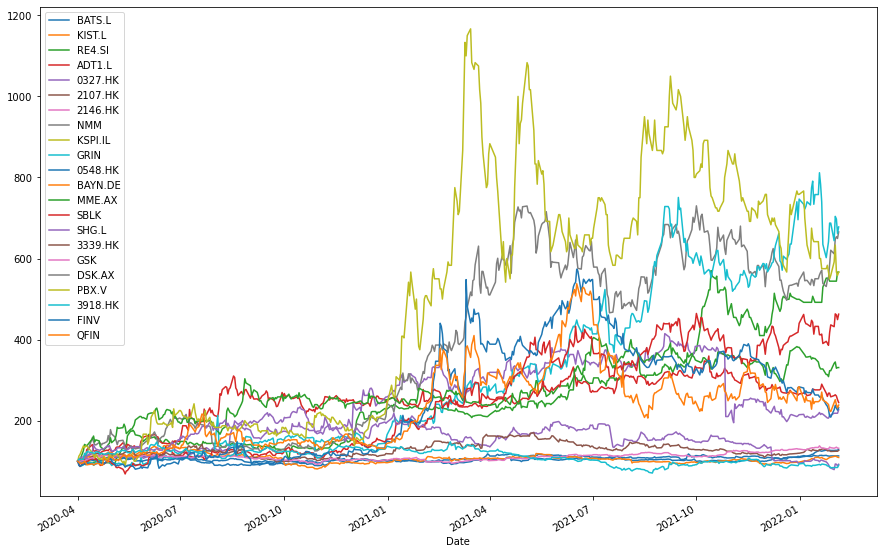

In [6]:
# Visualizamos la cotización en relación con el día uno

(mis_datos / mis_datos.iloc[0] * 100).plot(figsize = (15,10));
plt.show()

### Comprobar la correlación existente entre las diferentes empresas

In [7]:
# De cara a diversificar la inversión se recomienda invertir en empresas con comportamientos diferentes.

valor_referencia = 0.6 # Se puede cambiar para jugar con los resultados

diversificado = pd.DataFrame()
diversificado["Tickers"] = mis_datos.columns
diversificado["Diversificado"] = 0
diversificado.index = diversificado["Tickers"]
del(diversificado["Tickers"])

correlacion_tickers = mis_datos.corr()

mis_activos=tickers

for ticker in mis_activos:
    mayor_correlacion = correlacion_tickers[ticker].abs().sort_values()
    print("El ticker " + ticker + " tiene la siguiente correlación con:", sep=" ", end="\n")
    print(mayor_correlacion[mayor_correlacion > valor_referencia], end="\n\n")
    for empresas in mis_datos.columns:
        if correlacion_tickers[ticker].abs().sort_values()[empresas] < valor_referencia:
            diversificado["Diversificado"][empresas] += 1
            
propuestas_divers = pd.DataFrame()
propuestas_divers["Diversificado"] = diversificado["Diversificado"].sort_values(ascending=False)

El ticker BATS.L tiene la siguiente correlación con:
GSK       0.606282
SHG.L     0.639624
BATS.L    1.000000
Name: BATS.L, dtype: float64

El ticker KIST.L tiene la siguiente correlación con:
MME.AX     0.674074
3918.HK    0.678004
SBLK       0.723446
2146.HK    0.738643
SHG.L      0.753909
KSPI.IL    0.754019
GSK        0.840489
GRIN       0.898600
RE4.SI     0.951773
KIST.L     1.000000
Name: KIST.L, dtype: float64

El ticker RE4.SI tiene la siguiente correlación con:
ADT1.L     0.638073
2146.HK    0.644773
PBX.V      0.675337
3918.HK    0.716118
GSK        0.733649
MME.AX     0.785892
NMM        0.793178
KSPI.IL    0.800805
SBLK       0.878770
GRIN       0.921325
KIST.L     0.951773
RE4.SI     1.000000
Name: RE4.SI, dtype: float64

El ticker ADT1.L tiene la siguiente correlación con:
FINV       0.632386
RE4.SI     0.638073
PBX.V      0.638994
NMM        0.663188
GRIN       0.685772
SBLK       0.721703
0327.HK    0.735619
KSPI.IL    0.784959
MME.AX     0.801940
ADT1.L     1.000000
N

# Los valores estrella son los primeros del listado:

La mayor puntuación de "Diversificado" será el tamaño de la muestra -1 (la propia empresa). Por tanto, las que tengan un valor más bajo significa que correlacionan entre sí y por tanto no favorece a la estrategia de diversificación.

In [8]:
# Vista resumida para saber qué valores que se estén estudiando han pasado la prueba de "diversificación".

nombre_de_los_tickers = pd.read_excel("Cartera para Análisis.xlsx")
estudiar_diversificado = tickers
valores_diversificados_0 = propuestas_divers[propuestas_divers.index.isin(estudiar_diversificado)]
valores_diversificados = valores_diversificados_0.sort_values(by='Diversificado', ascending=False)
valores_diversificados_def = valores_diversificados.merge(nombre_de_los_tickers, left_on="Tickers", right_on="Yahoo")
valores_diversificados_def

,Diversificado,Empresas,Yahoo,Precio de compra,Acciones,Valor euros compra
0,21,Bayer,BAYN.DE,45.400,100,4540.00
1,21,First Service,2107.HK,0.710,40000,3183.64
2,19,BATS,BATS.L,2550.000,120,3616.31
3,18,Shanta Gold,SHG.L,8.800,30000,3119.95
4,16,Lonking,3339.HK,2.700,17000,5145.39
5,16,Shenzhen Expressway,0548.HK,7.300,8000,6546.64
6,15,Roiserv,2146.HK,4.400,7000,3452.68
7,14,QFIN,QFIN,19.260,1,19.26
8,13,Dusk,DSK.AX,2.690,1,2.69
9,13,GlaxoSmithKline,GSK,42.810,75,2849.69


### Añadir la evolución del precio y el marco temporal de la muestra

In [9]:
# Creo una tabla que muestra la evolución del valor de la cotización con respecto al día anterior.

retorno = (mis_datos / mis_datos.shift(1)) - 1

# Y etiqueto cada registro con el año en que se recoge. Antes estaba con el trimestre pero no ayuda al análisis.

def trimestrar (fecha):
    año = str(fecha)[2:4]
    mes = str(fecha)[5:7]
    trimestre = ((int(mes) - 1) // 3) + 1
    codigo = str(año) + "T" + str(trimestre)
    return codigo

def indicar_año (fecha):
    año = str(fecha)[2:4]
    codigo = str(año)
    return codigo

mis_datos["Periodo"] = [indicar_año(i) for i in mis_datos.index]
periodos = mis_datos["Periodo"].unique()

# Análisis mediante regresión simple

C:\Users\Usuario\AppData\Local\Temp/ipykernel_16420/2030488467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nueva_col[len(mis_datos.columns)-1]="Periodo"


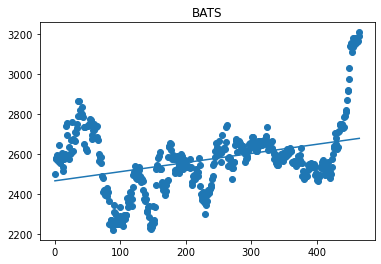

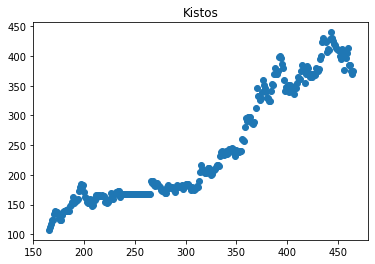

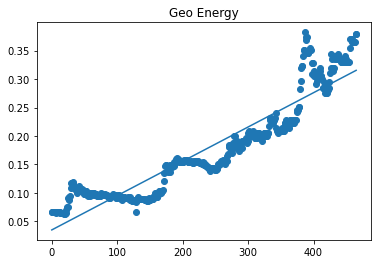

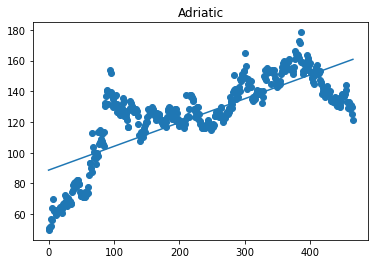

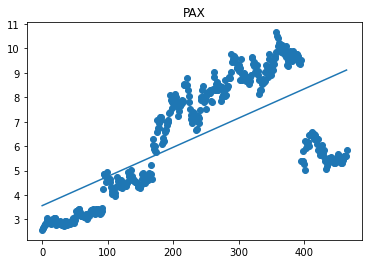

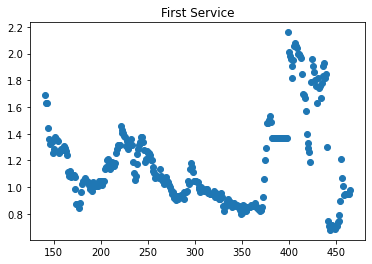

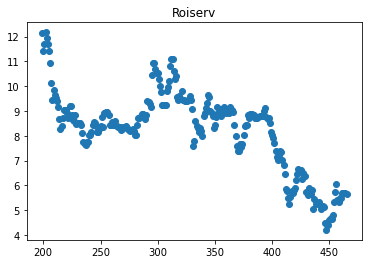

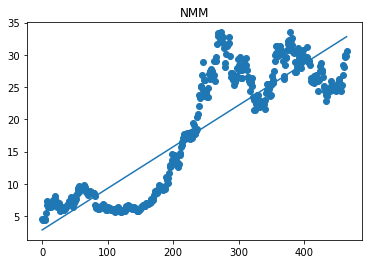

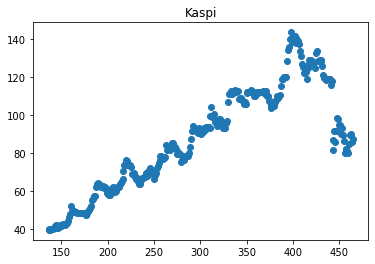

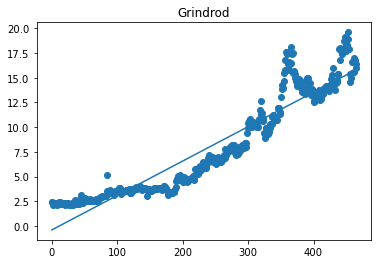

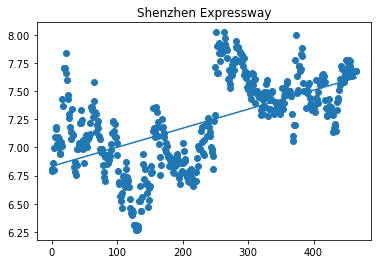

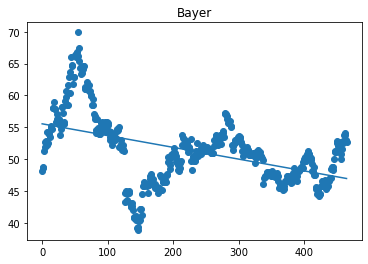

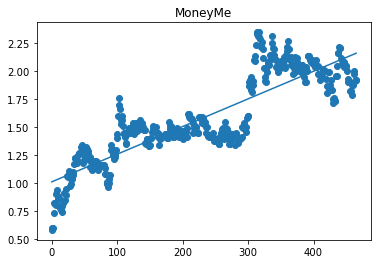

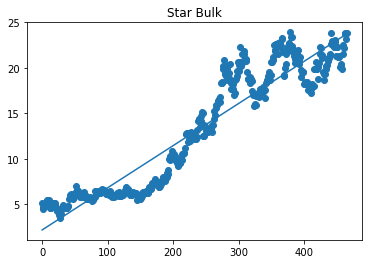

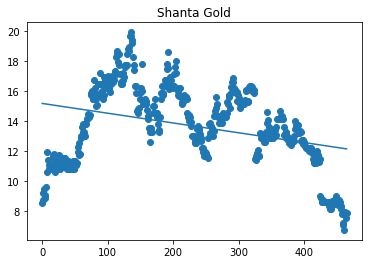

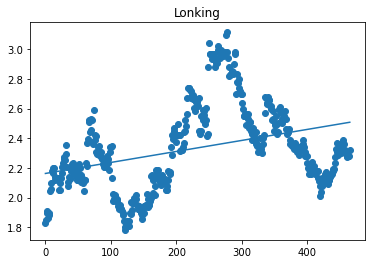

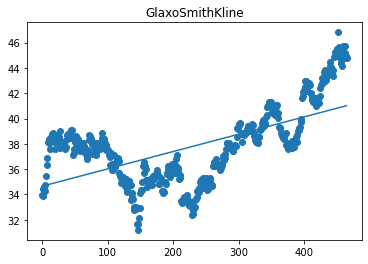

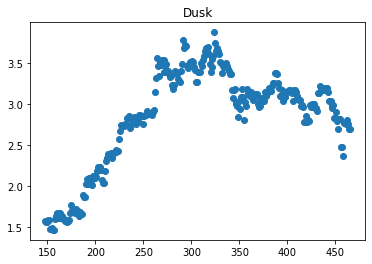

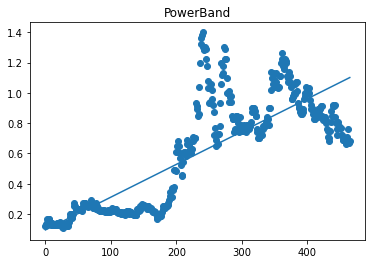

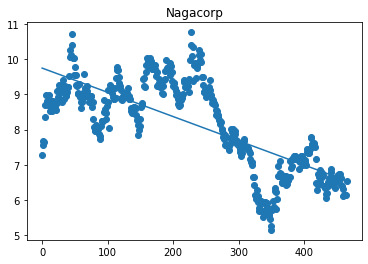

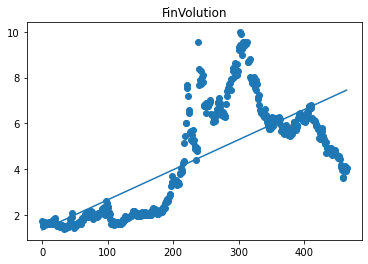

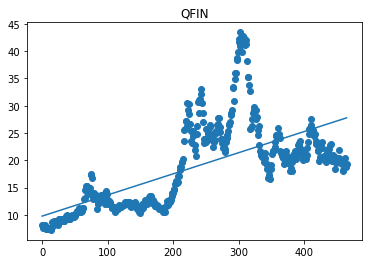

In [10]:
nueva_col = mi_excel.Empresas
nueva_col[len(mis_datos.columns)-1]="Periodo"
mis_datos.columns = nueva_col

for ticker in mis_datos.columns[:-1]: #Con el -1 le quito la columna final de "Periodo"

    empresa_regresion = mis_datos[ticker]

    cotizacion = empresa_regresion.values

    tiempo = np.array(range(len(cotizacion)))

    reg = sm.OLS(cotizacion, tiempo).fit()

    slope, intercept, r_value, p_value, std_err = stats.linregress(tiempo, cotizacion)

    def fitline(b):
        return intercept + slope * b

    line = fitline(tiempo)

    plt.scatter(tiempo,cotizacion)
    plt.plot(tiempo,line)
    plt.title(ticker)
    plt.show()

# Análisis de Riesgo y Beneficio

In [11]:
@interact(Periodo_utilizado=periodos)
def lectura_resultados(Periodo_utilizado):
    mis_datos_analizados = mis_datos[mis_datos["Periodo"]==Periodo_utilizado]
    mis_datos_analizados = mis_datos_analizados.drop("Periodo", axis=1)
    
    # Asumo que el peso de cada empresa es el mismo en mi cartera:
    pesos = [(1/len(mis_datos_analizados.columns)) for x in range(len(mis_datos_analizados.columns))]

    # Obtener el retorno trimestral con los datos de la muestra:
    retorno = (mis_datos_analizados / mis_datos_analizados.shift(1)) - 1
    retorno_anual = retorno.mean() * len(mis_datos_analizados) # Días al trimestre que funciona la bolsa
    pfolio = str(round(np.dot(retorno_anual, pesos)*100, 2))+ "%"

    # Calculando la Volatilidad, asociada al riesgo
    retorno = np.log(mis_datos_analizados / mis_datos_analizados.shift(1))
    volatilidad_anual = retorno[retorno.columns].std() * len(mis_datos_analizados) ** 0.5

    # Tabla de riesgo & beneficio
    riesgo_beneficio = pd.concat([retorno_anual, volatilidad_anual], axis=1)
    riesgo_beneficio.columns=["Beneficio","Riesgo"]
        
    return riesgo_beneficio    

interactive(children=(Dropdown(description='Periodo_utilizado', options=('20', '21', '22'), value='20'), Outpu…

In [12]:
tabla_Bene = pd.DataFrame()
tabla_Ries = pd.DataFrame()

for period in periodos:
    tabla_Bene[str(period)] = lectura_resultados(period).Beneficio
    tabla_Ries[str(period)] = lectura_resultados(period).Riesgo

In [13]:
# Evolución anual del beneficio por empresa.

@interact(Empresa = tabla_Bene.index)
def evolucion_beneficio(Empresa):

    for ticker in tabla_Bene.index:
        grosor = 1
        if ticker==Empresa:
            grosor = 4
        tabla_Bene.loc[ticker].plot(linewidth=grosor, figsize=(15,10))

interactive(children=(Dropdown(description='Empresa', options=('BATS', 'Kistos', 'Geo Energy', 'Adriatic', 'PA…

# Animación Riesgo-Beneficio trimestral

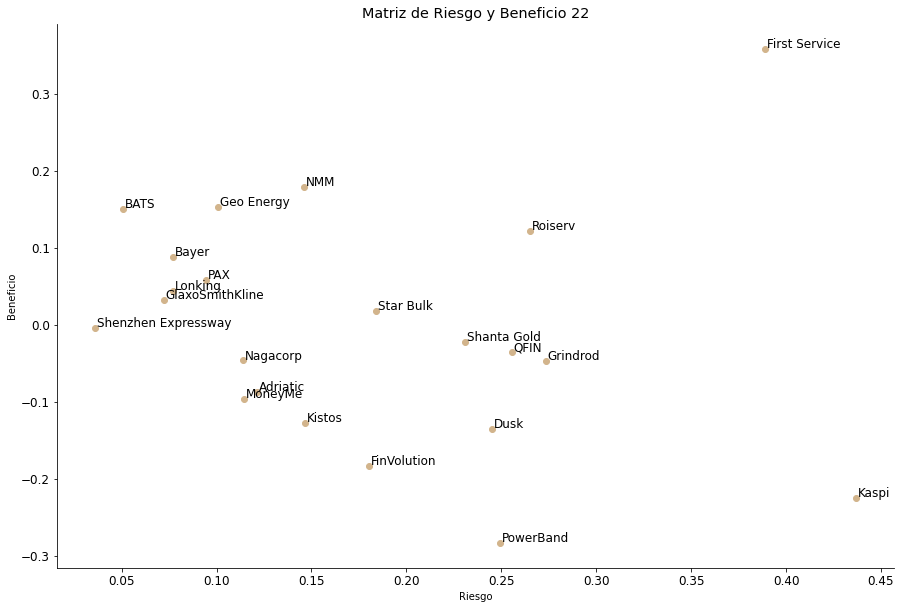

In [14]:
fig, ax = plt.subplots(figsize=(15,10));

def riesgo_vs_beneficio(periodo):
    ax.clear()
    lectura_parcial = lectura_resultados(periodo).dropna()
    eje_y = lectura_parcial.Riesgo
    eje_x = lectura_parcial.Beneficio

    for empresa in lectura_parcial.index:
        ax.text(lectura_parcial.Riesgo[empresa] + 0.001, \
                lectura_parcial.Beneficio[empresa] + 0.001, \
                str(empresa), color='black')#, fontweight='bold')

    ax.scatter(eje_y, eje_x, color=["tan"])
    ax.set_title('Matriz de Riesgo y Beneficio %s' %periodo)
    ax.set_xlabel('Riesgo')
    ax.set_ylabel('Beneficio')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.rcParams['font.size'] = 12
    #ax.axis([0.03, 0.5, -0.7, 0.7])
    
animacion_riesgovsben = animation.FuncAnimation(fig, riesgo_vs_beneficio, frames=periodos)
animacion_final = HTML(animacion_riesgovsben.to_jshtml())

In [15]:
animacion_final

# Visualización Riesgo-Beneficio trimestral

In [16]:
@interact(Periodo_utilizado=periodos)
def visualizacion_resultados(Periodo_utilizado):

    riesgo_beneficio = lectura_resultados(Periodo_utilizado).dropna()
    plt.rcParams['figure.figsize']=15,10

    visualizacion_RB = sns.regplot(data=riesgo_beneficio, x="Riesgo", y="Beneficio", fit_reg=True, marker="o", \
                                   color="skyblue")#, scatter_kws={'s':400}

    for line in range(0,riesgo_beneficio.shape[0]):
         visualizacion_RB.text(riesgo_beneficio.Riesgo[line]+0.002, riesgo_beneficio.Beneficio[line], \
                               riesgo_beneficio.index[line], horizontalalignment='left', size='medium', \
                               color='black', weight='semibold')

interactive(children=(Dropdown(description='Periodo_utilizado', options=('20', '21', '22'), value='20'), Outpu…

# Crear una fórmula con lo de abajo:

# Analizando la beta de una acción

In [17]:
accion_beta = "BAYN.DE"
mercado = "^GDAXI"
acciones_para_beta = [accion_beta, mercado]
data = pd.DataFrame()
for ticker in acciones_para_beta:
    data[ticker] = wb.DataReader(ticker, data_source='yahoo', start=fecha_inicio_analisis, end=fecha_fin_analisis)['Adj Close']  
    
sec_returns = np.log( data / data.shift(1) )
cov = sec_returns.cov() * dias_a_mano
cov_with_market = cov.iloc[0,1]
market_var = sec_returns[mercado].var() * dias_a_mano
beta_de_la_accion = cov_with_market / market_var
round(beta_de_la_accion,4)

0.9779

--> Aquí todavía se puede mejorar incluyendo otra columna en el excel con el mercado contra el que se compara y hacerlo con todas

# Comprobar si las empresas han estado bien elegidas - Sin efecto divisa ni dividendos (para esto está Portfolio Performance)

In [18]:
paso_intermedio = list(mis_datos.iloc[-1].values)
paso_final = paso_intermedio[:-1]
mi_excel["Valor accion"] = paso_final

In [19]:
# Asignar el último valor a las empresas del archivo

paso_intermedio = list(mis_datos.iloc[-1].values)
paso_final = paso_intermedio[:-1]
mi_excel["Valor accion"] = paso_final
mi_excel["% Variación"] = (mi_excel["Valor accion"] - mi_excel["Precio de compra"]) / mi_excel["Precio de compra"]
mi_excel["Valor actual"] = mi_excel["Valor euros compra"] * mi_excel["Valor accion"] / mi_excel["Precio de compra"]
mi_excel["Beneficios"] = mi_excel["Valor actual"] - mi_excel["Valor euros compra"]
mi_excel = mi_excel[mi_excel["Acciones"]!=1] #Quito las que aun no he comprado

act = mi_excel["Valor actual"].sum()
ant = mi_excel["Precio de compra"].sum()
beneficios = act - ant
margen = (act - ant) / ant
print("El margen de beneficio ha sido de",margen.round(2),"% lo que da un beneficio total de",beneficios.round(),"€.")

El margen de beneficio ha sido de 34.39 % lo que da un beneficio total de 110036.0 €.


In [20]:
# Azul para las empresas con ganancias y rojo para las empresas con pérdidas

colores = []

for empresa in mi_excel["Beneficios"]:
    if empresa>=0:
        colores.append("Blue")
    else:
        colores.append("Red")

In [21]:
# Ordeno el dataset para que la gráfica se vea mejor

mi_excel = mi_excel.sort_values(["Valor euros compra"], ascending=False)
mi_excel = mi_excel.reset_index().drop("index", axis=1)

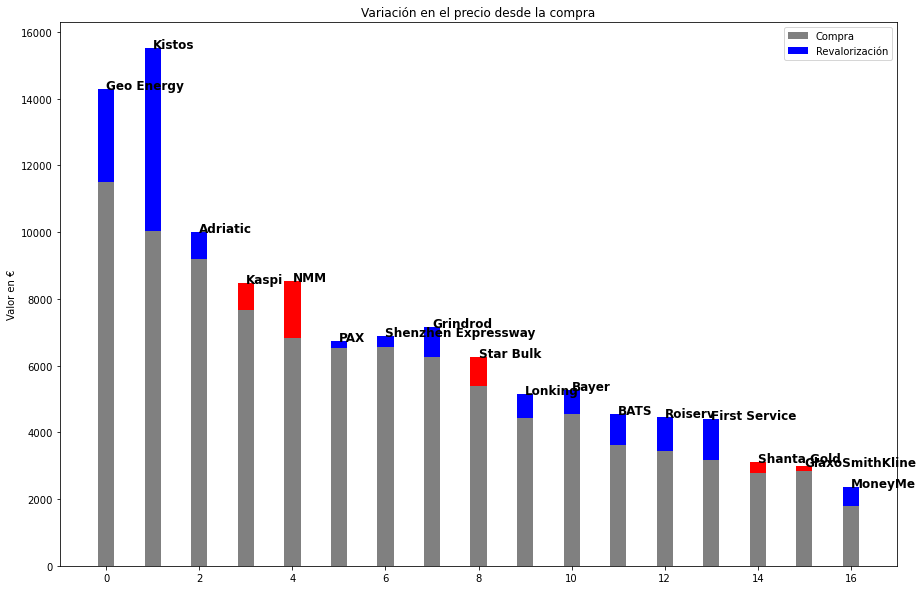

In [22]:
N = mi_excel.shape[0]
menMeans = mi_excel['Valor euros compra']
womenMeans = mi_excel['Beneficios']
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

p1 = ax.bar(ind, menMeans, width, color="gray", label='Compra')
p2 = ax.bar(ind, womenMeans, width, color=colores, bottom=menMeans, label='Revalorización')

ax.axhline(0, color='grey', linewidth=0.8)
ax.set_ylabel('Valor en €')
ax.set_title('Variación en el precio desde la compra')

posicion = 0
for empresa in mi_excel["Empresas"]:
    plt.text(posicion, \
             max(mi_excel["Valor actual"][posicion],mi_excel["Valor euros compra"][posicion]),\
             mi_excel["Empresas"][posicion], fontsize=12, fontweight='bold')
    posicion += 1

ax.legend()

plt.show()

# Los datos finales de la cartera son:

In [23]:
mi_excel

,Empresas,Yahoo,Precio de compra,Acciones,Valor euros compra,Valor accion,% Variación,Valor actual,Beneficios
0,Geo Energy,RE4.SI,0.306,58000,11501.62,0.380000,0.241830,14283.057337,2781.437337
1,Kistos,KIST.L,242.200,3500,10018.12,375.000000,0.548307,15511.127168,5493.007168
2,Adriatic,ADT1.L,132.110,6400,9992.17,121.500000,-0.080312,9189.680229,-802.489771
3,Kaspi,KSPI.IL,96.600,100,8463.25,87.599998,-0.093168,7674.748314,-788.501686
4,NMM,NMM,24.380,320,6812.52,30.540001,0.252666,8533.813250,1721.293250
5,PAX,0327.HK,6.000,10000,6726.00,5.830000,-0.028333,6535.429914,-190.570086
6,Shenzhen Expressway,0548.HK,7.300,8000,6546.64,7.680000,0.052055,6887.423846,340.783846
7,Grindrod,GRIN,14.300,500,6244.81,16.370001,0.144755,7148.779366,903.969366
8,Star Bulk,SBLK,20.600,300,5397.61,23.830000,0.156796,6243.934266,846.324266
9,Lonking,3339.HK,2.700,17000,5145.39,2.320000,-0.140741,4421.223873,-724.166127
